In [1]:
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns
import cv2
import random
import os
import imageio
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

import tensorflow as tf
import tensorflow_addons as tfa
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.applications import resnet
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from keras.applications.resnet import ResNet50
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

import scipy.ndimage as ndi
from skimage.morphology import remove_small_objects, remove_small_holes, ball, disk, dilation, binary_erosion, erosion, closing, reconstruction, binary_closing, binary_dilation, binary_opening
from skimage import morphology, filters, measure, feature, segmentation, color , io , exposure
from skimage.filters import try_all_threshold, roberts, sobel
from skimage.color import gray2rgb , rgb2gray
from skimage.segmentation import clear_border
import scipy.misc
from collections import Counter

import warnings
warnings.simplefilter("ignore", UserWarning)


In [2]:
directory = r'D:\\PROJECTS\\LUNG_CANCER\dataset\\The_IQ_OTHNCCD_lung_cancer_dataset\\The_IQ_OTHNCCD_lung_cancer_dataset'

categories = ['Bengin_cases', 'Malignant_cases', 'Normal_cases']

In [3]:
# Utility Functions
def hist(image, title='Image'):
    '''Function for draw historgrame for values in image'''
    fig,ax= plt.subplots(figsize=(20,7),nrows=1,ncols=1)
    ax.hist(image.ravel(),bins=30,color='gray')
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    
    
def show(img, title='Image'):
    '''Function for visualize sigle image'''
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()
    
def load_scans(INPUT_FOLDER):
    '''Function for load scans'''
    imgs=[]
    for i in os.listdir(INPUT_FOLDER):
        imgs.append(cv2.imread(INPUT_FOLDER+'/'+i))
    return imgs

def show_slices(st,rows,cols):
    '''Function to load multiple images'''
    fig, axs = plt.subplots(rows,cols,figsize=(rows+5,cols+5))
    axs = axs.flatten()
    for i in range(rows*cols):
        axs[i].imshow(st[i],cmap='gray')
        axs[i].axis('off')
    plt.show()
    
def normalize(gray):
    '''Functoin for make all values in image between 0 and 1'''
    MIN_BOUND = gray.min()
    MAX_BOUND = gray.max()
    gray = (gray - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    gray[gray>1] = 1.
    gray[gray<0] = 0.
    return gray


In [4]:
size_data = {}
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    temp_list = []
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        height, width, channels = io.imread(filepath).shape
        temp_list.append(f"{height} x {width}")
    
    size_data[i] = dict(Counter(temp_list))

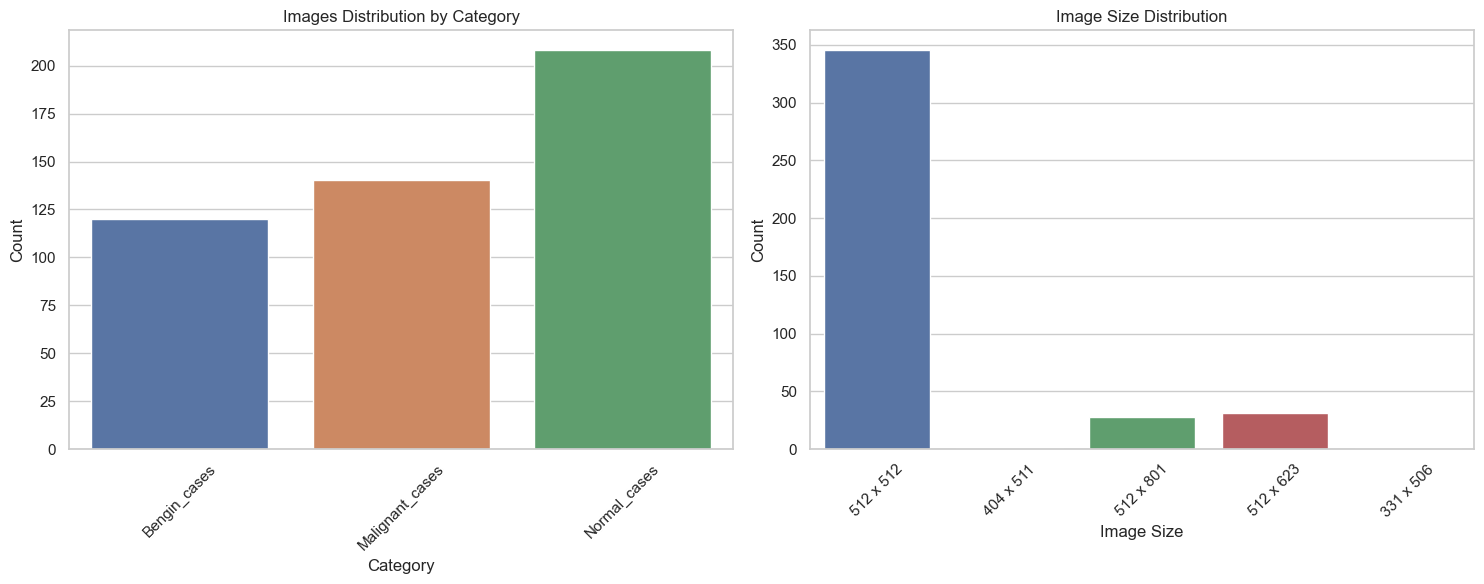

In [5]:
# Convert size_data to a pandas DataFrame
df = pd.DataFrame.from_dict(size_data, orient='index')

# Use Seaborn to create the first bar plot
sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 6))
sns.barplot(data=df.T, errorbar=None, ax=ax1)
ax1.set(xlabel='Category', ylabel='Count', title='Images Distribution by Category')
ax1.tick_params(axis='x', rotation=45)

# Use Seaborn to create the second bar plot
sns.set(style="whitegrid")
sns.barplot(data=df, errorbar=None, ax=ax2)
ax2.set(xlabel='Image Size', ylabel='Count', title='Image Size Distribution')
ax2.tick_params(axis='x', rotation=45)

# Adjust the layout of the plots
plt.tight_layout()
plt.show()


In [6]:
malignant_folder= f'D:\\PROJECTS\\LUNG_CANCER\dataset\\The_IQ_OTHNCCD_lung_cancer_dataset\\The_IQ_OTHNCCD_lung_cancer_dataset\\Malignant_cases'
data = load_scans(malignant_folder)

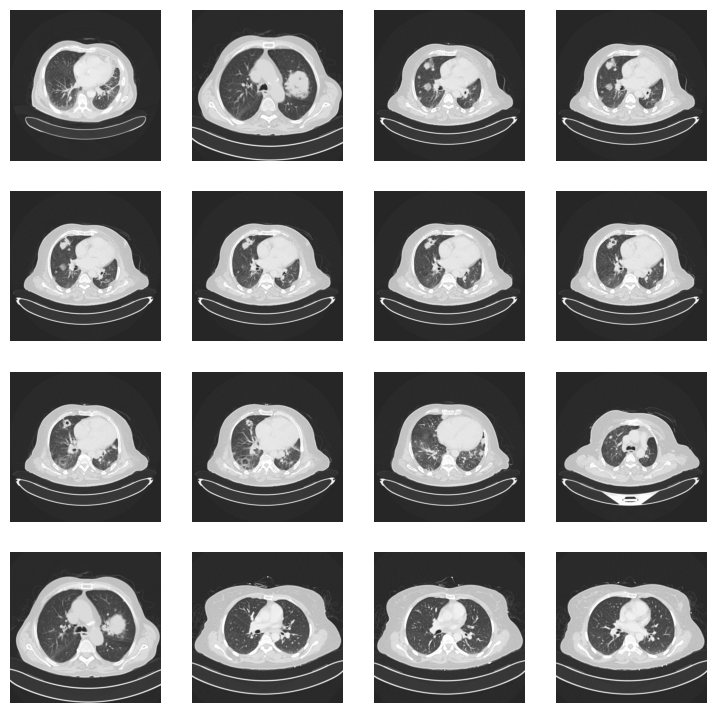

In [7]:
show_slices(data , 4,4)

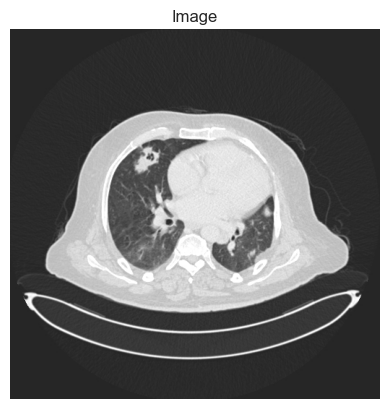

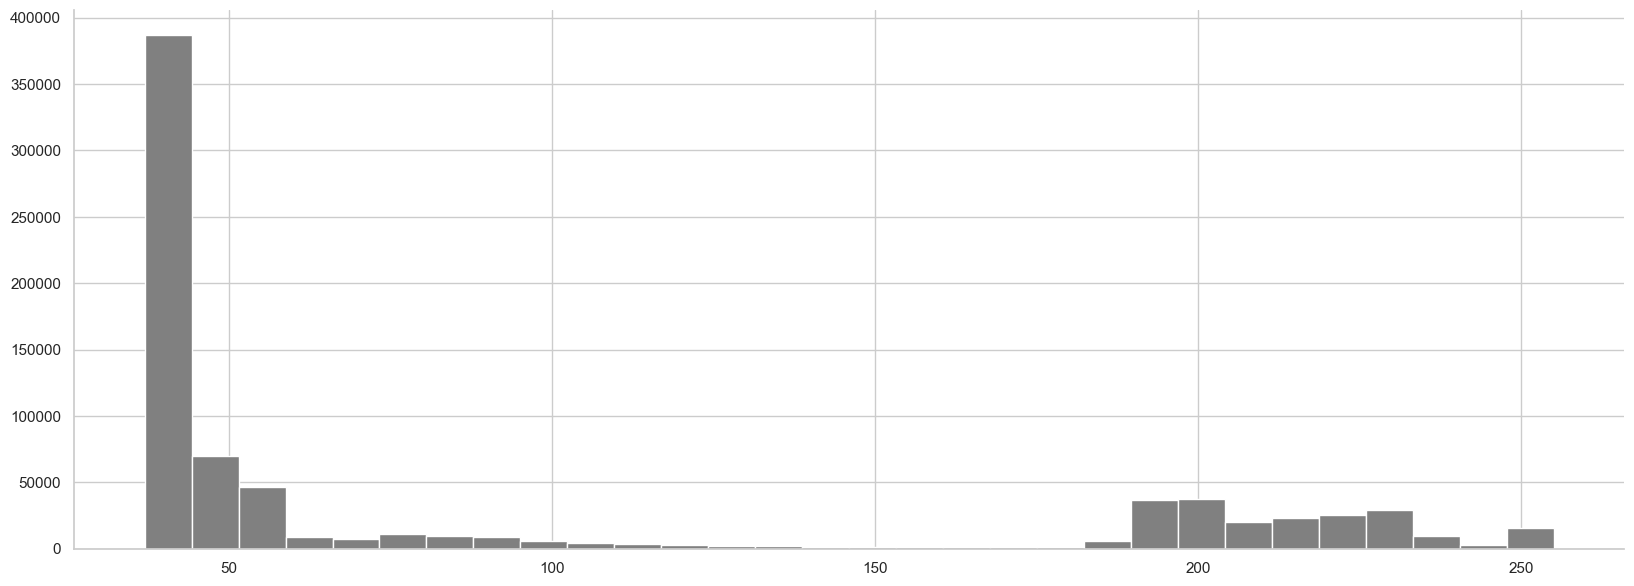

In [8]:
show(data[7])
hist(data[7])

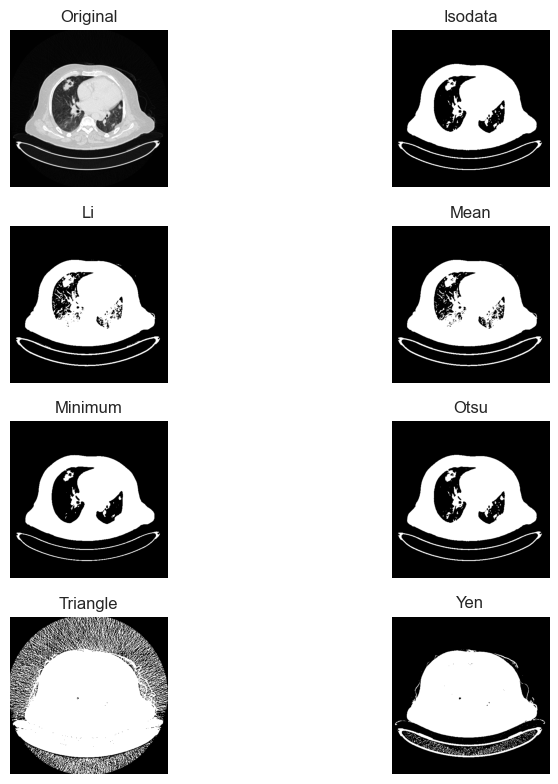

In [9]:
fig, ax = try_all_threshold(rgb2gray(data[7]), figsize=(10, 8), verbose=False)
plt.show()

In [10]:
import numpy as np
from skimage import measure

def filter_labels(labels, nlabels):
    corners = find_corners(labzels)
    object_sizes = calculate_objects_size(labels, corners)
    sorted_sizes = sort_labels_by_size(object_sizes)
    filtered_sizes = remove_small_objects(sorted_sizes)
    diaphragm_label = remove_diaphragm(labels, filtered_sizes)
    cleaned_labels = create_cleaned_labels(labels, filtered_sizes)
    left_label, right_label = get_left_and_right_labels(cleaned_labels)
    
    return [left_label, right_label]


def find_corners(labels):
    h, w = labels.shape[:2]
    corners = set([labels[0, 0], labels[0, w-1], labels[h-1, 0], labels[h-1, w-1]])
    return corners


def calculate_objects_size(labels, corners):
    object_sizes = Counter(labels.ravel())
    for corner in corners:
        del object_sizes[corner]
    return object_sizes


def sort_labels_by_size(object_sizes):
    sorted_sizes = sorted(object_sizes.items(), key=lambda x: x[1])
    return sorted_sizes


def remove_small_objects(sorted_sizes):
    filtered_sizes = [size_tuple for size_tuple in sorted_sizes if size_tuple[1] > 1000]
    return filtered_sizes


def remove_diaphragm(labels, filtered_sizes):
    h, w = labels.shape[:2]
    st = set()

    for i in range(h):
        if (labels[i, i],) in filtered_sizes:
            st.add((labels[i, i],))

        if (labels[h-i-1, i],) in filtered_sizes:
            st.add((labels[h-i-1, i],))

        if (labels[h-i-1, w-i-1],) in filtered_sizes:
            st.add((labels[h-i-1, w-i-1],))

    filtered_sizes = list(set(filtered_sizes) - st)

    diaphragm_label = label if label in labels else None
    return diaphragm_label

def create_cleaned_labels(labels, filtered_sizes):
    cleaned_labels = np.zeros_like(labels)
    for size_tuple in filtered_sizes:
        obj_label = size_tuple[0]
        obj_mask = np.where(labels == obj_label, 1, 0)
        cleaned_labels += obj_mask * obj_label
    return cleaned_labels


def get_left_and_right_labels(labels):
    regions = measure.regionprops(labels)
    centroids = [r.centroid for r in regions]
    
    # Sort the centroids based on their x-coordinate values
    centroids.sort(key=lambda x: x[0])
    
    # Find the two objects with smallest x-coordinates
    left_obj_centroid, right_obj_centroid = centroids[:2]
    left_label, right_label = None, None
    for region in regions:
        if tuple(region.centroid) == tuple(left_obj_centroid):
            left_label = region.label
        elif tuple(region.centroid) == tuple(right_obj_centroid):
            right_label = region.label
            
    return left_label, right_label


In [11]:
import numpy as np
from skimage.transform import resize
from skimage.color import rgb2gray, gray2rgb
from skimage import filters, measure
import scipy.ndimage as ndi

def normalize(image):
    # Normalize image values to be in the range of 0 to 1
    return (image - np.min(image)) / (np.max(image) - np.min(image))

def filter_labels(labels, nlabels):
    # Filter the labels to select the left and right lungs
    # Modify this function based on the specific labeling scheme used in your segmentation output
    # Return the label numbers corresponding to the left and right lungs
    return 1, 2

def segmentation(slice, flag=0):
    # Convert image to grayscale if it's in color
    if len(slice.shape) == 3:
        slice = rgb2gray(slice)

    # Normalize image values to be in the range of 0 to 1
    img_eq = normalize(slice)

    # Binarize image to remove background
    thresh = filters.threshold_isodata(img_eq)
    binary = (img_eq < thresh)

    # Label the binary image to detect objects
    labels, nlabels = measure.label(binary, return_num=True)

    try:
        # Filter labels to select the left and right lungs
        first, second = filter_labels(labels, nlabels)
    except:
        return np.zeros((256, 256, 3))

    # Extract lungs with their colors from the original image
    lungs = np.where((labels == first) | (labels == second), 1, 0) * slice

    # Get bounding boxes of lungs and resize the image to a fixed size
    bboxes = ndi.find_objects(np.where((labels == first) | (labels == second), 1, 0))
    im_res = slice[bboxes[0]]
    new_size = (256, 256)
    image_resized = resize(im_res, new_size, order=0, mode='reflect', anti_aliasing=False)
    sharpened_image = filters.unsharp_mask(image_resized, radius=1, amount=1)

    if flag:
        show_slices([slice, img_eq, binary, labels, lungs, sharpened_image], 3, 2)

    return gray2rgb(sharpened_image)


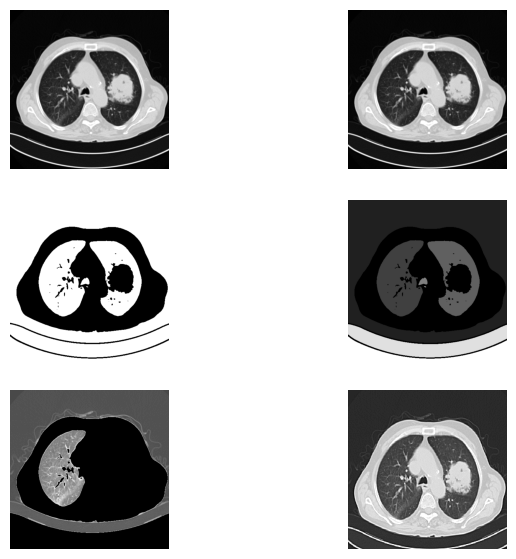

In [12]:
img = io.imread("D:\\PROJECTS\\LUNG_CANCER\\dataset\\The_IQ_OTHNCCD_lung_cancer_dataset\\The_IQ_OTHNCCD_lung_cancer_dataset\\Malignant_cases\\Malignant case (10).jpg")
res = segmentation(img,1)

In [13]:
import os
import cv2
import random
from collections import Counter
import numpy as np

# Initialize variables
data = []
img_size = 256

# Loop over categories and their files
for i, category in enumerate(categories):
    for file in os.listdir(os.path.join(directory, category)):
        img = cv2.imread(os.path.join(directory, category, file), 0)
        
        # Preprocess image and skip if maximum pixel value is 0
        img = segmentation(img)
        if img.max() == 0:
          pass
        
        # Append image and label to data list
        data.append([img, i])

# Shuffle data randomly
random.shuffle(data)
# Extract features and labels from data
X, y = zip(*data)

# Print length of X and count of each unique value in y
print('X length:', len(X))
print('y counts:', Counter(y))

# Convert features and labels to numpy arrays
X = np.array(X)
y = np.array(y)

X length: 1097
y counts: Counter({1: 561, 2: 416, 0: 120})


In [14]:
X.shape


(1097, 256, 256, 3)

In [15]:
y.shape

(1097,)

In [16]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(701, 256, 256, 3)
(176, 256, 256, 3)
(220, 256, 256, 3)


In [17]:
def apply_smote(X_train, y_train):
    # Flatten each image in X_train
    X_train_flat = np.reshape(X_train, (X_train.shape[0], -1))

    # Print the distribution of classes before applying SMOTE
    print("Class Distribution Before SMOTE:", Counter(y_train))

    # Apply SMOTE to balance the training set
    smote = SMOTE()
    X_train_sampled, y_train_sampled = smote.fit_resample(X_train_flat, y_train.ravel())

    # Reshape the flattened images back to their original shape
    X_train_sampled = np.reshape(X_train_sampled, (X_train_sampled.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3]))

    # Print the distribution of classes after applying SMOTE
    print("Class Distribution After SMOTE:", Counter(y_train_sampled))

    return X_train_sampled, y_train_sampled

In [18]:
X_train_sampled, y_train_sampled = apply_smote(X_train, y_train)
X_valid_sampled, y_valid_sampled = apply_smote(X_valid, y_valid)
X_test_sampled, y_test_sampled = apply_smote(X_test, y_test)

Class Distribution Before SMOTE: Counter({1: 357, 2: 266, 0: 78})
Class Distribution After SMOTE: Counter({2: 357, 1: 357, 0: 357})
Class Distribution Before SMOTE: Counter({1: 90, 2: 65, 0: 21})
Class Distribution After SMOTE: Counter({1: 90, 2: 90, 0: 90})
Class Distribution Before SMOTE: Counter({1: 114, 2: 85, 0: 21})
Class Distribution After SMOTE: Counter({2: 114, 1: 114, 0: 114})


In [19]:
print('X_train_sampled',X_train_sampled.shape)
print('X_valid_sampled',X_valid_sampled.shape)
print('X_test_sampled',X_test_sampled.shape)

X_train_sampled (1071, 256, 256, 3)
X_valid_sampled (270, 256, 256, 3)
X_test_sampled (342, 256, 256, 3)


In [20]:
from keras.utils import to_categorical

# Convert y_train to one-hot encoded format
y_train_onehot = to_categorical(y_train_sampled, num_classes=3)
y_train_onehot

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [21]:
print('X_train_sampled shape:', X_train_sampled.shape)
print('y_train shape:', y_train_onehot.shape)

# # Check if the number of samples is consistent
# if X_train_sampled.shape[0] != y_train_onehot.shape[0]:
#     # Adjust the data to have the same number of samples
#     min_samples = min(X_train_sampled.shape[0], y_train_onehot.shape[0])
#     X_train_sampled = X_train_sampled[:min_samples]
#     y_train_onehot = y_train_onehot[:min_samples]

# print('Adjusted X_train_sampled shape:', X_train_sampled.shape)
# print('Adjusted y_train shape:', y_train_onehot.shape)


X_train_sampled shape: (1071, 256, 256, 3)
y_train shape: (1071, 3)


In [22]:
y_train_onehot.shape

(1071, 3)

In [23]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.applications import VGG16
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Create an instance of the VGG16 model with pre-trained weights
vgg = VGG16(weights='imagenet', include_top=False, input_shape=X_train_sampled.shape[1:])

# Freeze the convolutional layers in the base model so they are not updated during training
for layer in vgg.layers:
    layer.trainable = False

# Add your own classification layers on top of the base model
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Use data augmentation to generate additional training data
datagen_train = ImageDataGenerator()
datagen_val = ImageDataGenerator()

# Split the data into training, validation, and testing sets
X_train, X_val, y_train, y_val = train_test_split(X_train_sampled, y_train_onehot, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

# Compile the model with a lower learning rate and categorical hinge loss
opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_hinge', optimizer=opt, metrics=['accuracy'])

# Define early stopping criteria to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Fit the model using the augmented data generator and early stopping
history = model.fit(datagen_train.flow(X_train, y_train, batch_size=16, shuffle=True),
                    epochs=10,
                    validation_data=datagen_val.flow(X_val, y_val, batch_size=16, shuffle=True),
                    callbacks=[early_stop],
                    shuffle=True)

Epoch 1/10
54/54 [==============================] - 25s 271ms/step - loss: 0.8007 - accuracy: 0.5923 - val_loss: 0.6385 - val_accuracy: 0.6916
Epoch 2/10
54/54 [==============================] - 11s 198ms/step - loss: 0.3821 - accuracy: 0.8294 - val_loss: 0.3168 - val_accuracy: 0.8879
Epoch 3/10
54/54 [==============================] - 11s 199ms/step - loss: 0.2527 - accuracy: 0.8960 - val_loss: 0.2077 - val_accuracy: 0.9065
Epoch 4/10
54/54 [==============================] - 11s 199ms/step - loss: 0.1583 - accuracy: 0.9509 - val_loss: 0.1992 - val_accuracy: 0.9159
Epoch 5/10
54/54 [==============================] - 11s 201ms/step - loss: 0.1115 - accuracy: 0.9696 - val_loss: 0.1527 - val_accuracy: 0.9626
Epoch 6/10
54/54 [==============================] - 11s 200ms/step - loss: 0.0877 - accuracy: 0.9696 - val_loss: 0.1366 - val_accuracy: 0.9626
Epoch 7/10
54/54 [==============================] - 11s 200ms/step - loss: 0.0736 - accuracy: 0.9801 - val_loss: 0.1206 - val_accuracy: 0.9439

In [24]:
# Assuming your trained model is stored in the 'model' variable
model.save('lung_cancer_detection_model.h5')
